In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from numba import njit, prange

In [6]:
from MonteCarloTorusSWAP import RandomConfig
from WavefnCFL import InitialJastrowsCFL, InitialJKMatrixCFL
from WavefnLaughlin import ThetaFunction
from utilities import fermi_sea_kx, fermi_sea_ky

In [4]:
@njit(parallel=True)
def UpdateJastrowsCFL(t: np.complex128, Lx: np.float64,
                      coords_tmp: np.array, Ks: np.array,
                      jastrows: np.array, jastrows_tmp: np.array,
                      JK_matrix_tmp: np.array, moved_particle: np.uint16):
    """
    Given new coordinates where we moved one single particle, this method
    updates the jastrow factors and the JK matrix.
    """
    Ne = coords_tmp.size

    # JK_matrix_tmp[:, moved_particle] = np.ones(Ne)

    for k in prange(Ne):
        JK_matrix_tmp[k, moved_particle] = np.exp(
            1j*np.real(Ks[k])*coords_tmp[moved_particle])
        for i in range(Ne):
            if i != moved_particle:
                jastrows_tmp[i, moved_particle, k] = ThetaFunction(
                    (coords_tmp[i] - coords_tmp[moved_particle] + 2*1j*Ks[k])/Lx, t, 1/2, 1/2)
                jastrows_tmp[moved_particle, i, k] = ThetaFunction(
                    (coords_tmp[moved_particle] - coords_tmp[i] + 2*1j*Ks[k])/Lx, t, 1/2, 1/2)

                JK_matrix_tmp[k, i] *= (jastrows_tmp[i, moved_particle, k] /
                                        jastrows[i, moved_particle, k])

                JK_matrix_tmp[k, moved_particle] *= jastrows_tmp[moved_particle,
                                                                 i, k]


In [9]:
Ne = 21
Lx = Ly = 12.28
t = 1j
Ks = (fermi_sea_kx[Ne] + 1j*fermi_sea_ky[Ne])*2*np.pi/Lx
coords = RandomConfig(Ne, Lx, Ly)
jastrows = np.zeros((Ne, Ne, Ne), dtype=np.complex128)
JK_matrix = np.zeros((Ne, Ne), dtype=np.complex128)

InitialJastrowsCFL(t, Lx, coords, Ks, jastrows)
jastrows_tmp = np.copy(jastrows)
InitialJKMatrixCFL(coords, Ks, jastrows, JK_matrix)

coords_tmp = np.copy(coords)
coords_tmp[3] += 1

In [10]:
UpdateJastrowsCFL(t, Lx, coords_tmp, Ks, jastrows, jastrows_tmp,
                      JK_matrix, moved_particle = 3)

UpdateJastrowsCFL.parallel_diagnostics(level=4)

 
 Parallel Accelerator Optimizing:  Function UpdateJastrowsCFL, 
C:\Users\crist\AppData\Local\Temp\ipykernel_22696\63327697.py (1)  


Parallel loop listing for  Function UpdateJastrowsCFL, C:\Users\crist\AppData\Local\Temp\ipykernel_22696\63327697.py (1) 
--------------------------------------------------------------------------------------------------|loop #ID
@njit(parallel=True)                                                                              | 
def UpdateJastrowsCFL(t: np.complex128, Lx: np.float64,                                           | 
                      coords_tmp: np.array, Ks: np.array,                                         | 
                      jastrows: np.array, jastrows_tmp: np.array,                                 | 
                      JK_matrix_tmp: np.array, moved_particle: np.uint16):                        | 
    """                                                                                           | 
    Given new coordinates wh

In [2]:
%load_ext line_profiler
from MonteCarloTorusSWAP import RunPSwapCFL, RunModSwapCFL, RunSignSwapCFL

In [3]:
region = 'circle'

In [5]:
%lprun -f RunSignSwapCFL RunSignSwapCFL(12, 24, 1j, 20000, 100, 0.1, region, boundary=0.23, save_config=False, save_result=False)

Torus dimensions 
Lx =  12.279920495357862 
Ly =  12.279920495357862
Iteration 1000 done, current acceptance ratio: 43.8 %
Iteration 2000 done, current acceptance ratio: 43.2 %
Iteration 3000 done, current acceptance ratio: 42.33 %
Iteration 4000 done, current acceptance ratio: 41.6 %
Iteration 5000 done, current acceptance ratio: 41.36 %
Iteration 6000 done, current acceptance ratio: 41.28 %
Iteration 7000 done, current acceptance ratio: 41.64 %
Iteration 8000 done, current acceptance ratio: 41.68 %
Iteration 9000 done, current acceptance ratio: 41.43 %
Iteration 10000 done, current acceptance ratio: 41.75 %
Iteration 11000 done, current acceptance ratio: 41.7 %
Iteration 12000 done, current acceptance ratio: 41.73 %
Iteration 13000 done, current acceptance ratio: 41.59 %
Iteration 14000 done, current acceptance ratio: 41.59 %
Iteration 15000 done, current acceptance ratio: 41.61 %
Iteration 16000 done, current acceptance ratio: 41.9 %
Iteration 17000 done, current acceptance ratio: 4

Timer unit: 1e-07 s

Total time: 20.1361 s
File: d:\fizica\phd\MonteCarlo\MonteCarlo\MonteCarloTorusSWAP.py
Function: RunSignSwapCFL at line 1419

Line #      Hits         Time  Per Hit   % Time  Line Contents
  1419                                           def RunSignSwapCFL(Ne: np.uint8, Ns: np.uint16, t: np.complex64,
  1420                                                              M: np.uint32, M0: np.uint32, step_size: np.float64,
  1421                                                              region_geometry: str, boundary: np.float64,
  1422                                                              kCM: np.uint8 = 0, phi_1: np.float64 = 0, phi_t: np.float64 = 0,
  1423                                                              save_config: np.bool_ = True, save_result: np.bool_ = True
  1424                                                              ):
  1425                                               """
  1426                                               Par

### Optimisation to-do
- for laughlin wavefn, store theta functions of current coords so we don't have to calcualte those O(n) again for the current step

In [ ]:
from cmath import exp

In [ ]:
@njit#(parallel=True)
def ThetaFunction(z: np.complex128, t: np.complex128, a: np.float64,
                  b: np.float64, n_max: np.uint32 = 1000
                  ) -> np.complex128:
    index = np.arange(-n_max, n_max, 1)
    x = t*a + 2*(z+b)
    terms = np.exp(1j*np.pi*(index+a)*(t*index + x))
    return np.sum(terms)

## How many theta functon terms to converge to machine precision

In [ ]:
N = 60
x, y = np.meshgrid(np.linspace(-2,2,N), np.linspace(-2,2,N), indexing='xy')
z = x + 1j*y
tf_grid_1 = np.zeros((N,N), dtype=np.complex128)
tf_grid_2 = np.zeros((N,N), dtype=np.complex128)

for i in range(N):
    for j in range(N):
        tf_grid_1[i,j] = ThetaFunction(z[i,j], 1j, 1/2, 1/2,6)
        tf_grid_2[i,j] = ThetaFunction(z[i,j], 1j, 1/2, 1/2,11)

In [ ]:
ThetaFunction(-0.5-0.5*1j, 1j, 1/2, 1/2,2500)

(2.3828557978614704+0j)

In [ ]:
np.sum(np.real(tf_grid_1-tf_grid_2)**2)

0.0

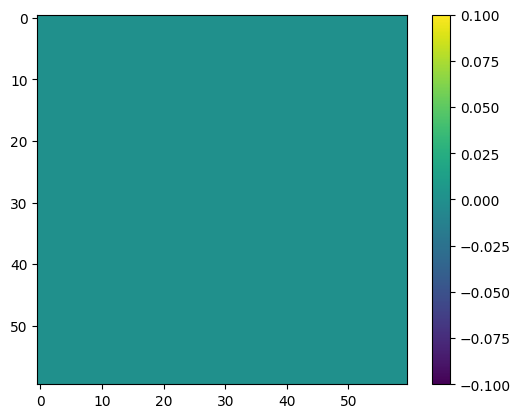

In [ ]:
plt.imshow(np.real(tf_grid_1-tf_grid_2))
plt.colorbar()

In [ ]:
#@jit#(parallel=True)
def TF1(z: np.complex128, t: np.complex128, a: np.float64,
                  b: np.float64, n_max: np.uint32 = 50
                  ) -> np.complex128:
    s=0
    x = t*a + 2*(z+b)
    for i in range(-n_max, n_max, 1):
        s += exp(1j*np.pi*(i+a)*(t*i + x))
    
    return s

In [ ]:
%%timeit

ThetaFunction(0.5+1*1j, 1j, 1/2, 1/2, 10)

693 ns ± 1.18 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [ ]:
%%timeit
TF1(0.5+0.5*1j, 1j, 1/2, 1/2, 10)

5.84 µs ± 51.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
ThetaFunction(0.5+0.5*1j, 1j, 1/2, 1/2)

(-2.3828557978614704-2.9181567256807615e-16j)

In [ ]:
ThetaFunction(0.5+0.5*1j, 1j, 1/2, 1/2)

(-2.3828557978614704-2.9181567256807615e-16j)